In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [4]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head(3)

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [ ]:
df_meta.info()

In [6]:
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head(3)

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0


In [ ]:
df_dicom.SeriesDescription.unique()

In [7]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(3)

0    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
Name: image_path, dtype: object

In [8]:
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head(3)

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
Name: image_path, dtype: object

In [9]:
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head(3)

5    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [10]:
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'


In [11]:
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])


Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [13]:
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [14]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head(3)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...


In [15]:
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        img_name = img[13].split("/")[2]
        data.iloc[index,13] = roi_img_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)

In [16]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [17]:
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [18]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [19]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head(3)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [20]:
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(mass_train['cropped_image_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: cropped_image_file_path, dtype: object


In [22]:
print(mass_train['ROI_mask_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: ROI_mask_file_path, dtype: object


Full Mammograms:



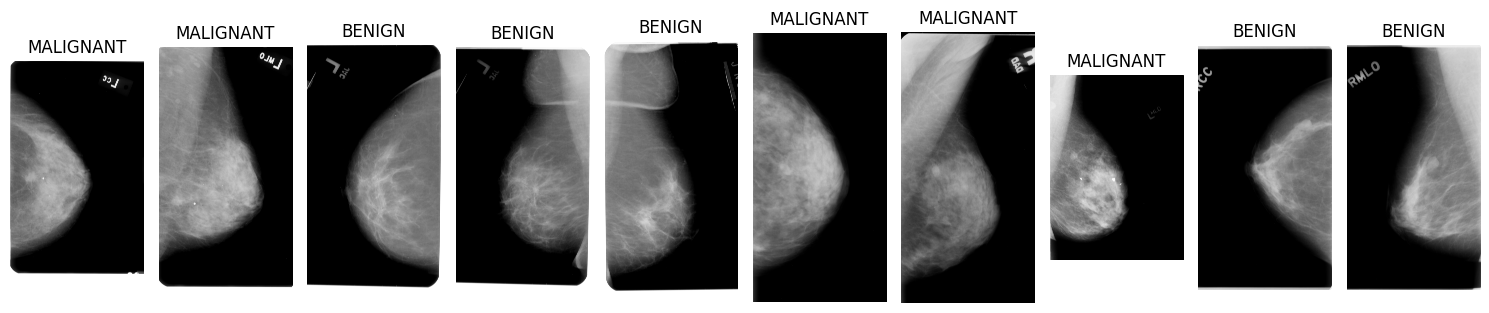

Cropped Mammograms:



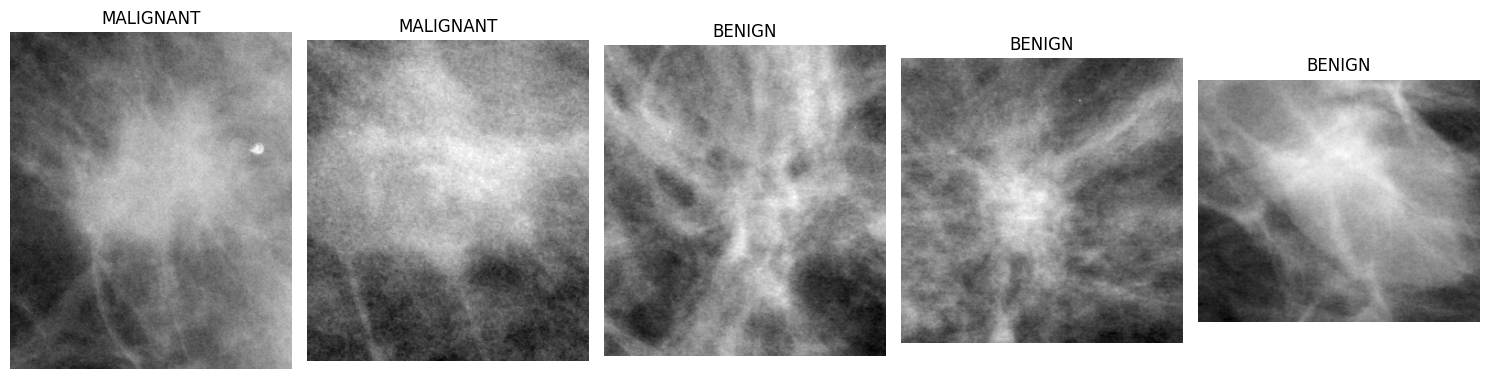

ROI mask:



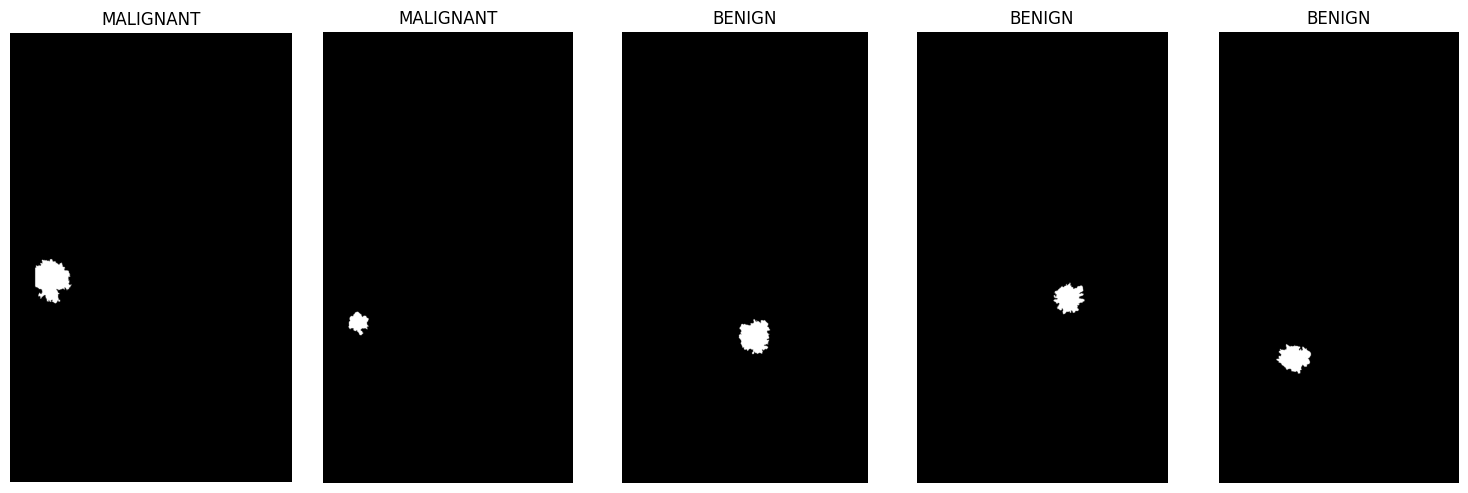

In [23]:
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 10)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)
print('ROI mask:\n')
display_images('ROI_mask_file_path', 5)

In [24]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')

In [25]:
print(f'Shape of calc_train: {calc_train.shape}')
print(f'Shape of calc_test: {calc_test.shape}')

Shape of calc_train: (1546, 14)
Shape of calc_test: (326, 14)


In [26]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import cv2
import numpy as np
import os

def image_processor(image_path, target_size):
    """Preprocess images for CNN model, including CLAHE for contrast enhancement"""
    # Obtenir le chemin absolu
    absolute_image_path = os.path.abspath(image_path)
    
    # Lire l'image
    image = cv2.imread(absolute_image_path)
    
    # Convertir en niveaux de gris (nécessaire pour CLAHE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Appliquer CLAHE pour améliorer le contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    
    # Convertir l'image CLAHE en RGB (3 canaux) pour la compatibilité avec les CNN (si nécessaire)
    image_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)
    
    # Uniformiser la taille
    resized_image = cv2.resize(image_rgb, (target_size[1], target_size[0]))
    
    # Normaliser les valeurs des pixels entre 0 et 1
    image_array = resized_image / 255.0
    
    return image_array


# Évaluer la fonction image_processor

In [27]:
# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

a. Histogramme de contraste avant et après traitement

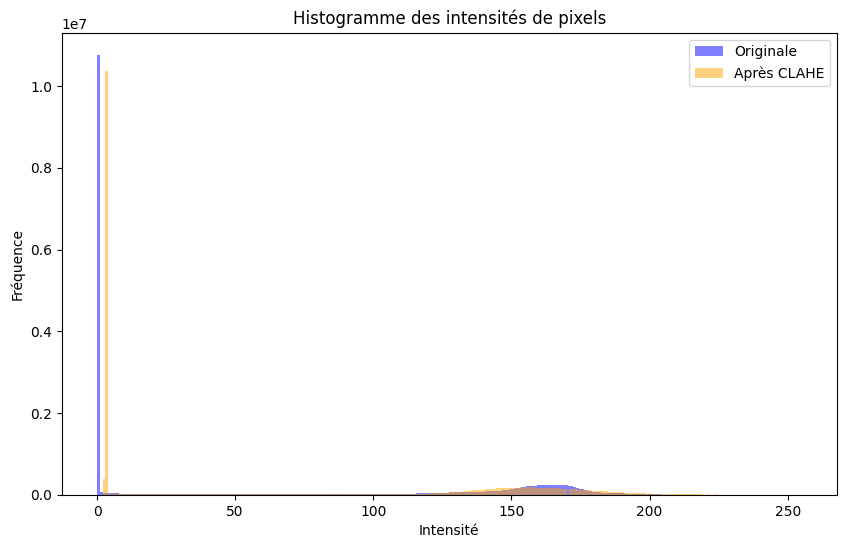

In [28]:
def evaluate_contrast_enhancement(image_path, target_size):
    """Compare les histogrammes de l'image originale et après CLAHE"""
    # Charger l'image originale
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Appliquer CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(original_image)

    # Tracer les histogrammes
    plt.figure(figsize=(10, 6))
    plt.hist(original_image.ravel(), bins=256, alpha=0.5, label='Originale', color='blue')
    plt.hist(enhanced_image.ravel(), bins=256, alpha=0.5, label='Après CLAHE', color='orange')
    plt.legend()
    plt.title("Histogramme des intensités de pixels")
    plt.xlabel("Intensité")
    plt.ylabel("Fréquence")
    plt.show()

# Exemple d'évaluation sur une image aléatoire
# Define the target size
target_size = (224, 224, 3)

random_image = full_mass.sample(1)['image_file_path'].values[0]
evaluate_contrast_enhancement(random_image, target_size)


L’histogramme présenté compare les intensités de pixels dans une image mammographique avant et après l'application de la technique CLAHE (Contrast Limited Adaptive Histogram Equalization). Voici une interprétation détaillée :

---

### 1. **Observation globale** :
   - **Histogramme avant traitement (bleu)** :
     - La majorité des pixels sont regroupés autour des valeurs basses (proches de 0), ce qui signifie que l'image originale est majoritairement sombre ou faiblement contrastée.
   - **Histogramme après traitement (jaune)** :
     - Les intensités de pixels sont réparties de manière plus large et uniforme, bien que le pic principal reste autour des basses valeurs.

---

### 2. **Interprétation** :
   - Avant CLAHE :
     - Les pixels ont une plage d’intensités restreinte, ce qui est typique pour les images médicales comme les mammographies. Ces images doivent être sombres pour ne pas cacher des détails subtils, mais cela limite parfois leur contraste.
   - Après CLAHE :
     - La distribution des intensités est élargie : les valeurs moyennes et hautes ont été augmentées, rendant les détails plus visibles, notamment dans les zones sombres.
     - Cependant, CLAHE conserve la nature médicale de l’image : la répartition ne devient pas artificiellement uniforme, ce qui est important pour préserver les informations diagnostiques.

---

### 3. **Conclusion sur la qualité d’amélioration** :
   - Le traitement par CLAHE améliore localement le contraste des régions peu visibles sans déformer globalement l'image.
   - Cela peut être bénéfique pour des tâches comme la détection de masses ou de calcifications, car les structures importantes deviennent plus visibles.

---

### 4. **Limite observable** :
   - Si l'histogramme reste fortement concentré autour de basses valeurs, cela peut indiquer que l'image est encore sombre après CLAHE. Cela peut être corrigé en ajustant les paramètres de CLAHE, comme `clipLimit` ou la taille de la grille (`tileGridSize`).

En résumé, ce traitement améliore significativement le contraste des mammographies, un aspect clé pour les modèles de deep learning dans la détection des anomalies.

In [29]:


# Define the target size
target_size = (224, 224, 3)

# Apply preprocessor to train data
full_mass['processed_images'] = full_mass['image_file_path'].apply(lambda x: image_processor(x, target_size))

# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 1, 'BENIGN_WITHOUT_CALLBACK': 0} 

# Convert the processed_images column to an array
X_resized = np.array(full_mass['processed_images'].tolist())

# Apply class mapper to pathology column
full_mass['labels'] = full_mass['pathology'].replace(class_mapper)
# Vérifier le nombre de classes uniques après mapping
num_classes = len(full_mass['labels'].unique())
print(f"Nombre de classes uniques : {num_classes}")


# Split data into train, test, and validation sets (70, 20, 10)
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)
#[1, 0] pour les tumeurs bénignes et [0, 1] pour les tumeurs malignes
# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

/tmp/ipykernel_30/3261224705.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_mass['labels'] = full_mass['pathology'].replace(class_mapper)


Nombre de classes uniques : 2


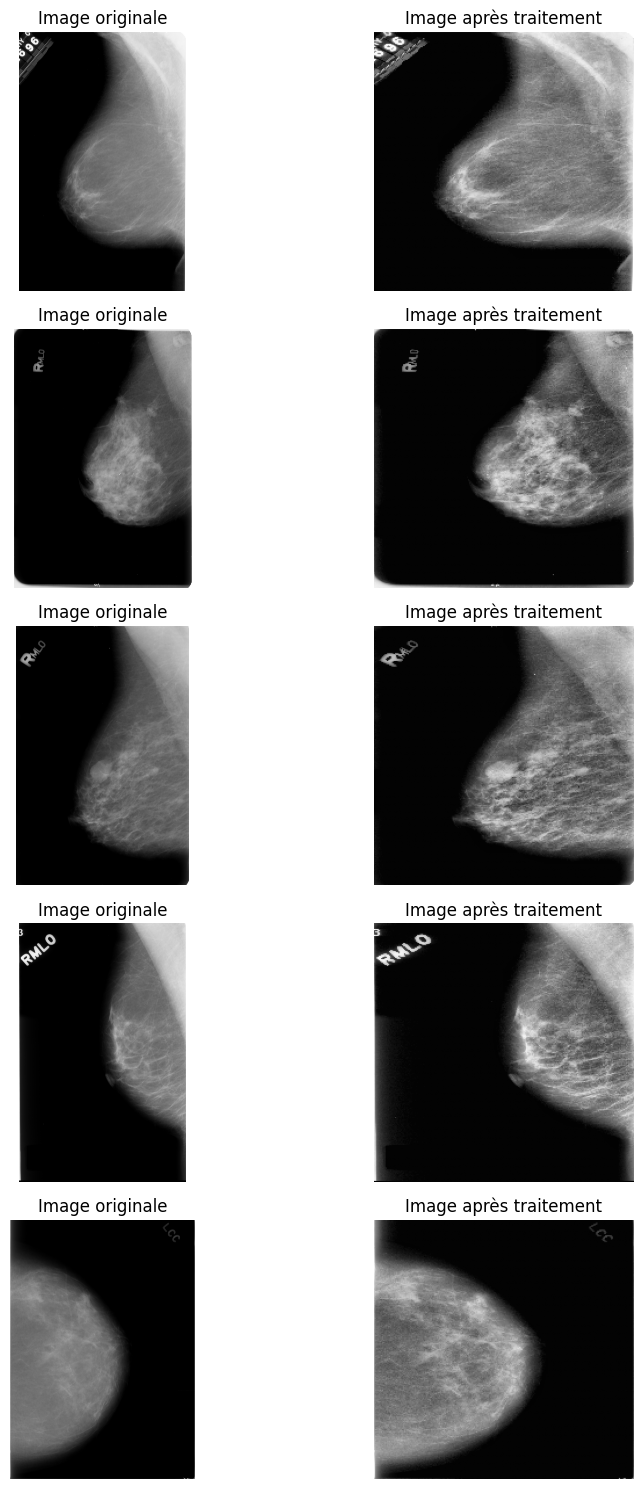

In [30]:
def display_processed_vs_original(full_mass, num_samples=5):
    """Affiche les images originales (brutes) et après traitement côte à côte"""
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 15))

    # Échantillonner des données aléatoires
    sample_data = full_mass.sample(num_samples)

    for i, (index, row) in enumerate(sample_data.iterrows()):
        # Charger l'image brute
        original_image = cv2.imread(row['image_file_path'])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Récupérer l'image traitée
        processed_image = row['processed_images']

        # Afficher l'image brute
        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title("Image originale")
        axes[i, 0].axis("off")

        # Afficher l'image traitée
        axes[i, 1].imshow(processed_image)
        axes[i, 1].set_title("Image après traitement")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Appeler la fonction pour afficher la comparaison
display_processed_vs_original(full_mass, num_samples=5)


labels
1    1555
0     141
Name: count, dtype: int64


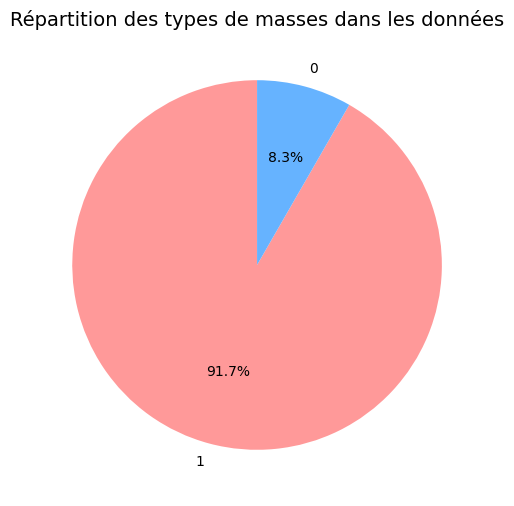

In [31]:
# Comptage des classes
value_counts = full_mass['labels'].value_counts()
print(value_counts)

# Création d'un graphique circulaire
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Répartition des types de masses dans les données', fontsize=14)
plt.show()


# **UnderSampling** 

In [32]:
from sklearn.utils import resample

# Diviser le dataset en deux sous-ensembles : une pour chaque classe
class_1 = full_mass[full_mass['labels'] == 1]
class_0 = full_mass[full_mass['labels'] == 0]

# Réaliser l'undersampling aléatoire de la classe majoritaire (class_1) pour correspondre à la taille de class_0
class_1_downsampled = resample(class_1, 
                               replace=False,         # Ne pas échantillonner avec remplacement
                               n_samples=len(class_0),  # Taille cible égale à celle de class_0
                               random_state=42)       # Fixer un random_state pour la reproductibilité

# Combiner les deux classes pour former un dataset équilibré
balanced_full_mass = pd.concat([class_1_downsampled, class_0])

# Mélanger les données pour éviter un biais lié à l'ordre des classes
balanced_full_mass = balanced_full_mass.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifier la répartition des classes après équilibrage
print(balanced_full_mass['labels'].value_counts())


labels
1    141
0    141
Name: count, dtype: int64


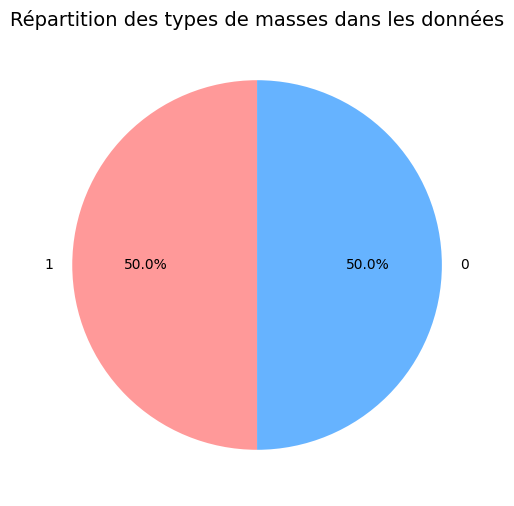

In [33]:
# Comptage des classes
value_counts = balanced_full_mass['labels'].value_counts()

# Création d'un graphique circulaire
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Répartition des types de masses dans les données', fontsize=14)
plt.show()


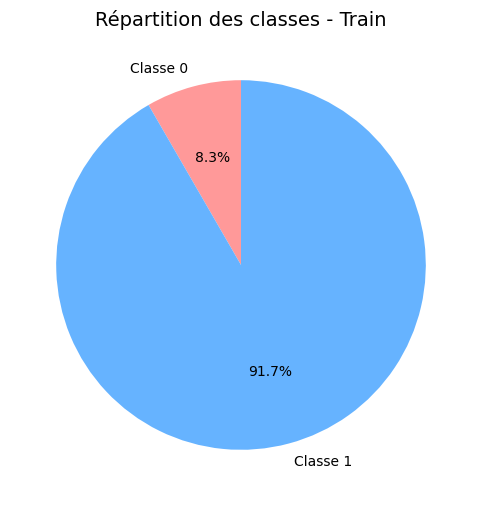

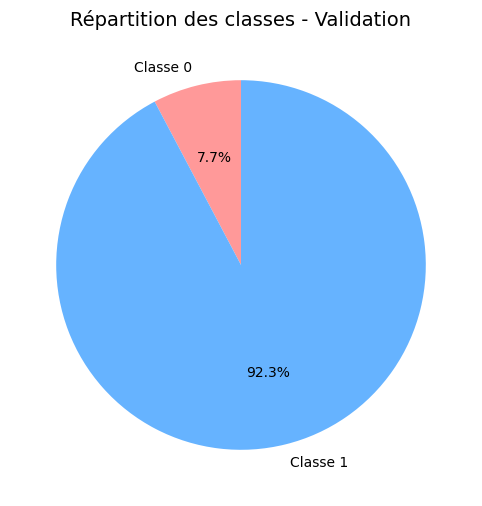

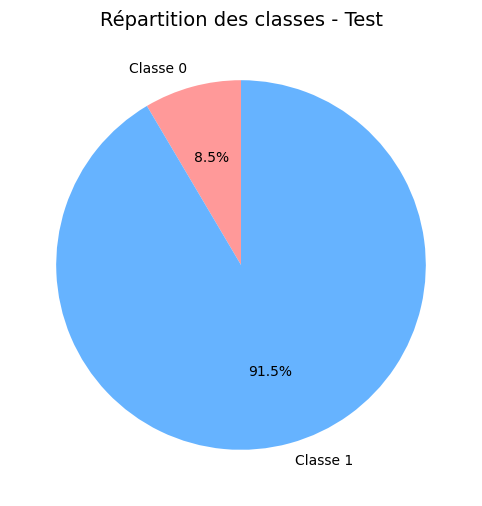

In [34]:
# Fonction pour afficher un graphique circulaire pour chaque ensemble
def plot_class_distribution(y_data, title):
    # Comptage des classes
    value_counts = np.sum(y_data, axis=0)  # Somme des colonnes one-hot
    class_labels = [f"Classe {i}" for i in range(len(value_counts))]
    
    # Création d'un graphique circulaire
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
    plt.title(title, fontsize=14)
    plt.show()

# Afficher la répartition des classes dans les ensembles
plot_class_distribution(y_train, "Répartition des classes - Train")
plot_class_distribution(y_val, "Répartition des classes - Validation")
plot_class_distribution(y_test, "Répartition des classes - Test")


**split the data set**

In [35]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Extraire les données et les labels
X_balanced = np.array(balanced_full_mass['processed_images'].tolist())
y_balanced = balanced_full_mass['labels'].values

# Diviser en ensembles d'entraînement et de test (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.15, random_state=42, stratify=y_balanced
)

# Encodage one-hot pour les labels
num_classes = len(np.unique(y_balanced))  # Nombre de classes uniques

# Vérification des tailles
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de y_train : {y_train.shape}")
print(f"Taille de X_test : {X_test.shape}")
print(f"Taille de y_test : {y_test.shape}")


Taille de X_train : (239, 224, 224, 3)
Taille de y_train : (239,)
Taille de X_test : (43, 224, 224, 3)
Taille de y_test : (43,)


# **VGG 19**

In [36]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.applications import VGG19
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPool2D
from keras import optimizers
from keras import losses
from sklearn import metrics


# Vérification de la forme des données
rows, cols, color = X_train[0].shape
print(f"Taille d'une image d'entrée : {X_train[0].shape}")

# Charger le modèle de base VGG19 pré-entraîné sur ImageNet

base_model = VGG19(
    input_shape=(224, 224, 3), 
    # weights='/kaggle/input/vgg19/other/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    weights = '/kaggle/input/vgg_16_1/keras/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False
)

# Construire le modèle final
model = Sequential()
model.add(base_model)  # Ajouter le modèle pré-entraîné
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Sortie unique pour la classification binaire

# Geler les couches du modèle de base pour empêcher leur entraînement initial
for layer in base_model.layers:
    layer.trainable = False

# Résumé du modèle
model.summary()

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4),  # Optimiseur Adam avec un learning rate adapté
              loss=BinaryCrossentropy(),         # Perte adaptée à la classification binaire
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10,  # Vous pouvez augmenter ou diminuer ce nombre
                    batch_size=32,  # Taille des batchs
                    verbose=1)

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Prédictions
y_pred = (model.predict(X_test) > 0.5).astype(int)


Taille d'une image d'entrée : (224, 224, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 110s 13s/step - accuracy: 0.6643 - loss: 0.6263 - val_accuracy: 0.6512 - val_loss: 0.6108
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 13s/step - accuracy: 0.8880 - loss: 0.3104 - val_accuracy: 0.6279 - val_loss: 0.6187
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 103s 13s/step - accuracy: 0.9048 - loss: 0.2303 - val_accuracy: 0.6512 - val_loss: 0.6010
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 13s/step - accuracy: 0.9529 - loss: 0.1738 - val_accuracy: 0.6512 - val_loss: 0.5885
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 148s 14s/step - accuracy: 0.9502 - loss: 0.1291 - val_accuracy: 0.6512 - val_loss: 0.5916
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 13s/step - accuracy: 0.9881 - loss: 0.0730 - val_accuracy: 0.6744 - val_loss: 0.5974
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 108s 14s/step - accuracy: 0.9909 - loss: 0.0749 - val_accuracy: 0.6744 - val_loss: 0.5910
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 107s 14s/step - accuracy: 0.9935 - loss: 0.0451 - val_accuracy: 0.6744 - val_loss:

In [37]:
# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.74        22
           1       0.88      0.33      0.48        21

    accuracy                           0.65        43
   macro avg       0.74      0.64      0.61        43
weighted avg       0.73      0.65      0.61        43


Matrice de confusion:
[[21  1]
 [14  7]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step
Confusion Matrix:
[[21  1]
 [14  7]]


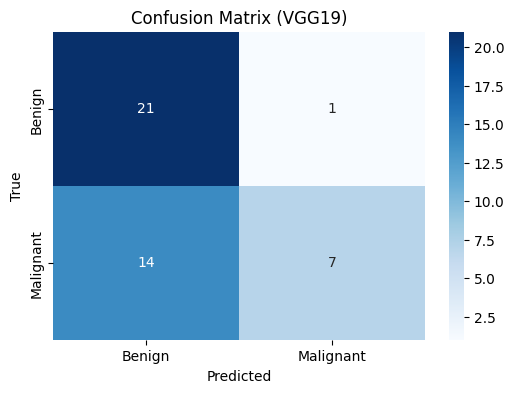


Classification Report:
              precision    recall  f1-score   support

      Benign       0.60      0.95      0.74        22
   Malignant       0.88      0.33      0.48        21

    accuracy                           0.65        43
   macro avg       0.74      0.64      0.61        43
weighted avg       0.73      0.65      0.61        43



In [38]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions (already done in your code)
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (VGG19)')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

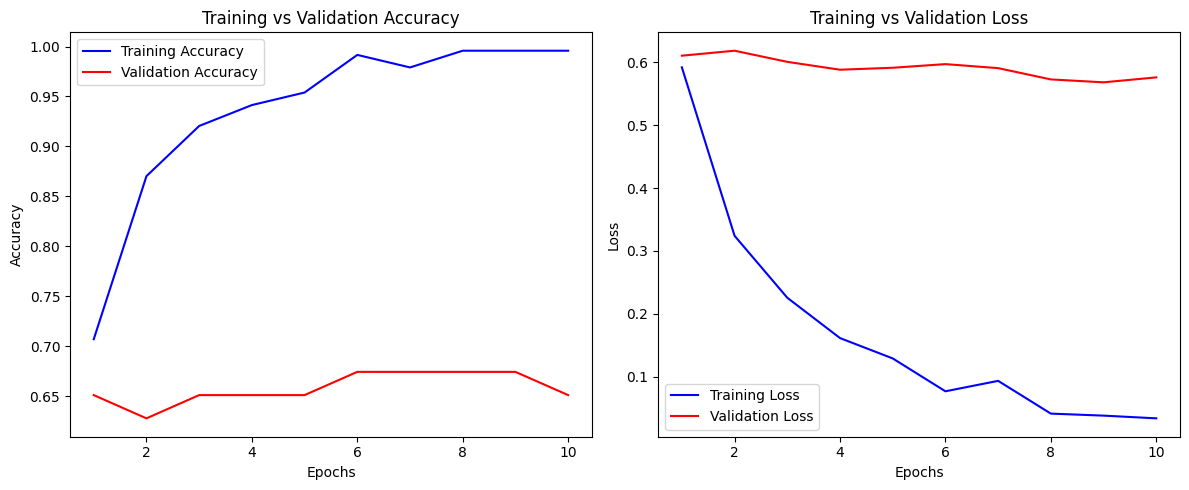

In [41]:
import matplotlib.pyplot as plt

# Extract history from model training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  # How many predicted malignant were correct?
print(f"Recall (Sensitivity): {recall:.4f}")  # How many actual malignant were detected?
print(f"F1-Score: {f1:.4f}")  # Harmonic mean of precision & recall


Test Accuracy: 0.6512
Precision: 0.8750
Recall (Sensitivity): 0.3333
F1-Score: 0.4828


2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step

ROC-AUC Score: 0.8766


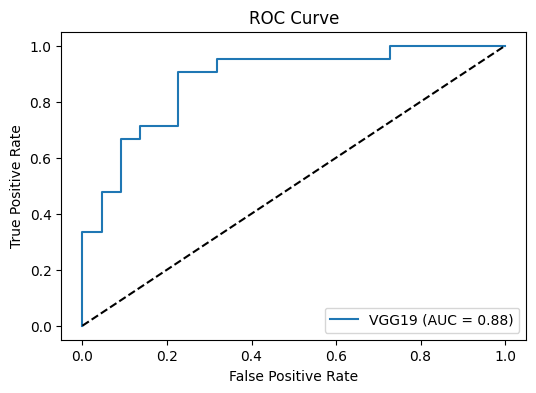

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities (not binary predictions)
y_prob = model.predict(X_test).ravel()

# ROC-AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'VGG19 (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step
Confusion Matrix:
[[20  2]
 [ 5 16]]


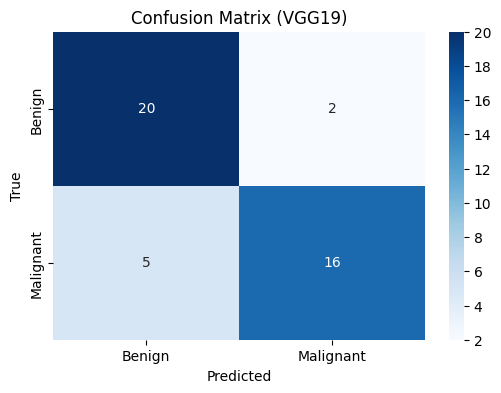


Classification Report:
              precision    recall  f1-score   support

      Benign       0.80      0.91      0.85        22
   Malignant       0.89      0.76      0.82        21

    accuracy                           0.84        43
   macro avg       0.84      0.84      0.84        43
weighted avg       0.84      0.84      0.84        43



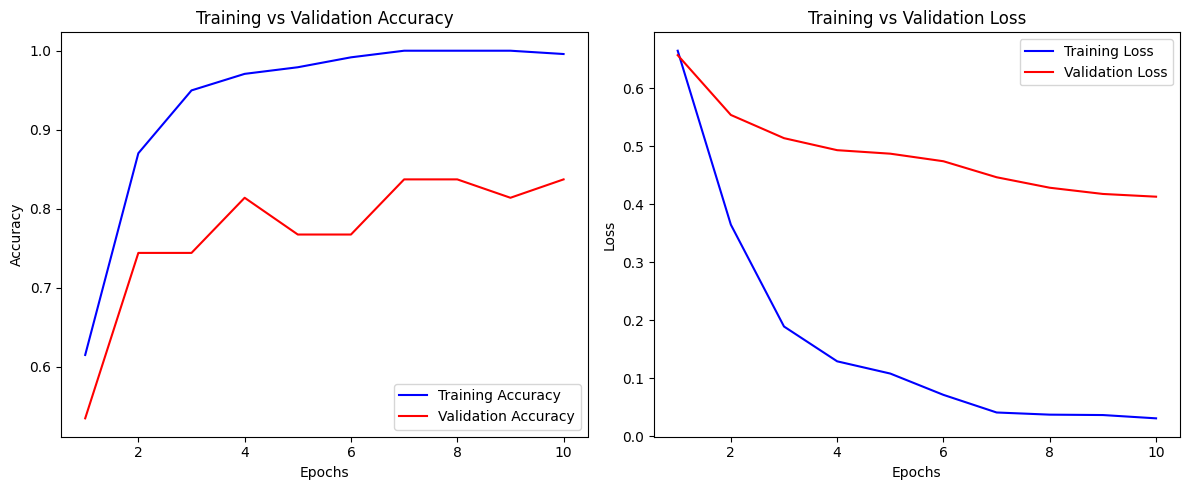

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

ROC-AUC Score: 0.9113


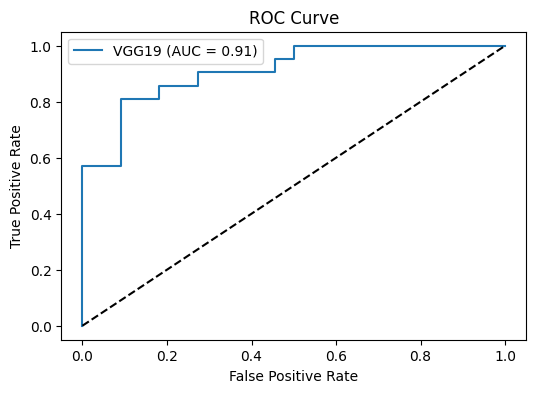

# **VGG16**

In [45]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.applications import VGG16  # Remplacer VGG19 par VGG16
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix

# Vérification de la forme des données
rows, cols, color = X_train[0].shape
print(f"Taille d'une image d'entrée : {X_train[0].shape}")

# Charger le modèle de base VGG16 pré-entraîné sur ImageNet
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    input_shape=(224, 224, 3),  # Taille de l'image d'entrée
    # weights='/kaggle/input/vgg16/other/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',  # Utiliser les poids pré-entraînés de ImageNet
    weights = '/kaggle/input/vgg_16_2/keras/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False  # Ne pas inclure la couche de classification finale
)





# Construire le modèle final
model = Sequential()
model.add(base_model)  # Ajouter le modèle pré-entraîné
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Sortie unique pour la classification binaire

# Geler les couches du modèle de base pour empêcher leur entraînement initial
for layer in base_model.layers:
    layer.trainable = False

# Résumé du modèle
model.summary()

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4),  # Optimiseur Adam avec un learning rate adapté
              loss=BinaryCrossentropy(),         # Perte adaptée à la classification binaire
              metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10,  # Vous pouvez augmenter ou diminuer ce nombre
                    batch_size=32,  # Taille des batchs
                    verbose=1)

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Prédictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Matrice de confusion
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))


Taille d'une image d'entrée : (224, 224, 3)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 11s/step - accuracy: 0.5697 - loss: 0.7131 - val_accuracy: 0.5349 - val_loss: 0.6572
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 0.8561 - loss: 0.4121 - val_accuracy: 0.7442 - val_loss: 0.5541
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 0.9433 - loss: 0.1852 - val_accuracy: 0.7442 - val_loss: 0.5140
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 11s/step - accuracy: 0.9664 - loss: 0.1330 - val_accuracy: 0.8140 - val_loss: 0.4933
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 151s 12s/step - accuracy: 0.9636 - loss: 0.1299 - val_accuracy: 0.7674 - val_loss: 0.4872
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 0.9937 - loss: 0.0693 - val_accuracy: 0.7674 - val_loss: 0.4742
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 12s/step - accuracy: 1.0000 - loss: 0.0421 - val_accuracy: 0.8372 - val_loss: 0.4466
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 12s/step - accuracy: 1.0000 - loss: 0.0388 - val_accuracy: 0.8372 - val_loss: 0.4285

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
Confusion Matrix:
[[20  2]
 [ 5 16]]


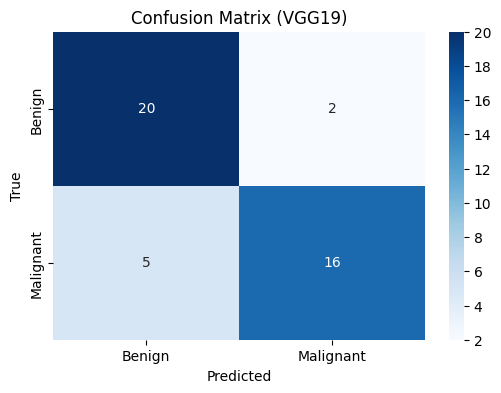


Classification Report:
              precision    recall  f1-score   support

      Benign       0.80      0.91      0.85        22
   Malignant       0.89      0.76      0.82        21

    accuracy                           0.84        43
   macro avg       0.84      0.84      0.84        43
weighted avg       0.84      0.84      0.84        43



In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions (already done in your code)
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (VGG19)')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

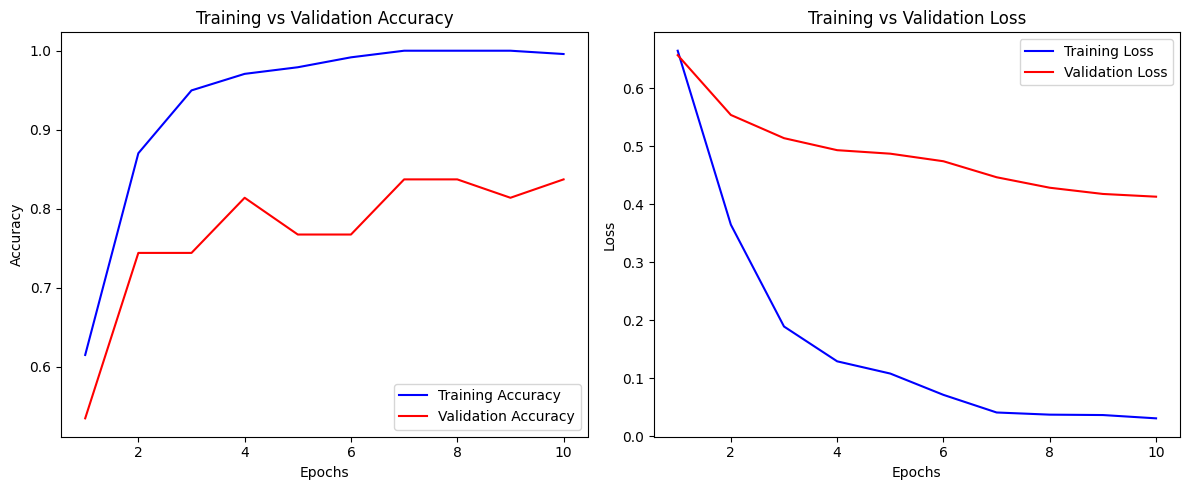

In [49]:
import matplotlib.pyplot as plt

# Extract history from model training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step

ROC-AUC Score: 0.9113


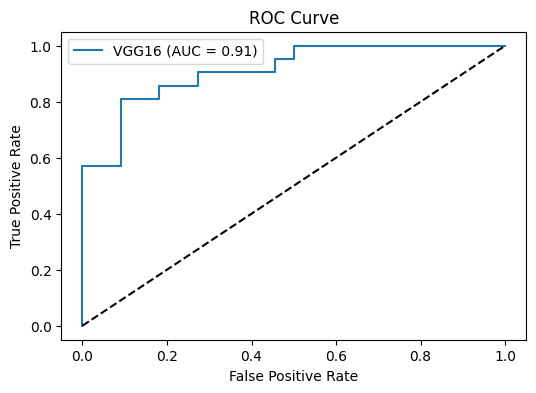

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

# Get predicted probabilities (not binary predictions)
y_prob = model.predict(X_test).ravel()

# ROC-AUC Score
auc = roc_auc_score(y_test, y_prob)
print(f"\nROC-AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'VGG16 (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# **MODEL XCEPTION**

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [37]:

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
num_classes = len(np.unique(y_balanced))  
# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.xception.Xception(include_top=False, weights="/kaggle/input/xception-weights/tensorflow2/default/1/xception_weights_tf_dim_ordering_tf_kernels_notop.h5",input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(num_classes, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

**Set Callback Parameters**

In [38]:
import tensorflow as tf
import numpy as np
import time

class MyCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch
        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.highest_tracc = 0.0
        self.lowest_vloss = np.inf
        self.ask_permission = 0

    def on_train_begin(self, logs=None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print('Do you want the model to ask you to halt the training [y/n]?')
        if hasattr(__builtins__, 'input'):
            ans = input('').strip().lower()
            self.ask_permission = 1 if ans == 'y' else 0
        print('{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^10s}{9:^8s}'.format(
            'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration'))
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        print(f'Training elapsed time: {int(hours)} hours, {int(minutes):02} minutes, {seconds:05.2f} seconds')
        self.model.set_weights(self.best_weights)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy', 0.0) * 100
        loss = logs.get('loss', 0.0)
        print(f'Processing batch {batch + 1} of {self.batches} - Accuracy: {acc:.3f} - Loss: {loss:.5f}', end='\r')

    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        ep_end = time.time()
        duration = ep_end - self.ep_start

        acc = logs.get('accuracy', 0.0)
        v_acc = logs.get('val_accuracy', 0.0)
        loss = logs.get('loss', 0.0)
        v_loss = logs.get('val_loss', 0.0)
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)) 
        current_lr = lr

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if self.highest_tracc > 0 else 0.0
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.stop_count += 1
                    self.count = 0
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if self.lowest_vloss < np.inf else 0.0
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
            else:
                self.count += 1
                if self.count >= self.patience:
                    lr *= self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr)
                    self.stop_count += 1
                    self.count = 0

        msg = f'{epoch + 1:^3}/{self.epochs:^4} {loss:^9.3f}{acc * 100:^9.2f}{v_loss:^9.5f}{v_acc * 100:^9.2f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count >= self.stop_patience:
            print(f'Training halted at epoch {epoch + 1} after {self.stop_patience} learning rate adjustments with no improvement.')
            self.model.stop_training = True
        elif self.ask_permission and epoch + 1 >= self.ask_epoch:
            print('Enter "H" to halt training or an integer for additional epochs:')
            ans = input().strip().lower() if hasattr(__builtins__, 'input') else '0'
            if ans == 'h':
                print(f'Training halted at epoch {epoch + 1} by user input.')
                self.model.stop_training = True
            else:
                try:
                    self.ask_epoch += int(ans)
                    print(f'Training will continue until epoch {self.ask_epoch}.')
                except ValueError:
                    print('Invalid input. Training will continue.')


In [39]:
# Configuration des paramètres
batch_size = 40  # Taille des lots
epochs = 40  # Nombre total d'époques
patience = 1  # Nombre d'époques pour ajuster le LR si la valeur surveillée ne s'améliore pas
stop_patience = 3  # Nombre d'époques avant d'arrêter si la valeur surveillée ne s'améliore pas
threshold = 0.9  # Si la précision de l'entraînement est < seuil, surveiller la précision, sinon surveiller la perte de validation
factor = 0.5  # Facteur de réduction du LR
ask_epoch = 5  # Nombre d'époques avant de demander si vous voulez arrêter l'entraînement

# Calcul du nombre de batches
batches = int(np.ceil(len(X_train) / batch_size))  # Nombre de batches par époque

# Création des callbacks
callbacks = [MyCallback(patience=patience, stop_patience=stop_patience, 
                        threshold=threshold, factor=factor, batches=batches, 
                        epochs=epochs, ask_epoch=ask_epoch)]

**Train model**

In [ ]:
# Entraînement du modèle
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=callbacks)


**Display model performance**

In [41]:
plot_training(history)

NameError: name 'plot_training' is not defined

**EVALUATE MODEL**

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

**Confusion Matrics and Classification Report**

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))